In [1]:
from main import get_preprocessed_data
from indicator_and_strategy.indicators import Indicator
from indicator_and_strategy.momentumstrategy import MomentumStrategy
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import talib
plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
df = get_preprocessed_data('yfinance')
df.head()

2024-05-30 23:07:39,066 - INFO - Fetching stock data for BTC-USD from 2017-01-01 to 2024-01-01
[*********************100%%**********************]  1 of 1 completed
2024-05-30 23:07:40,170 - INFO - Successfully fetched stock data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


In [3]:
columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
df.columns = columns
df

,date,open,high,low,close,adj_close,volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008
...,...,...,...,...,...,...,...
2551,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2552,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2553,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
2554,2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945


In [ ]:
df['sma'] = df['close'].rolling(window=5, min_periods=1).mean()
df['lma'] = df['close'].rolling(window=14, min_periods=1).mean()
df['buy'] = df['sma'] > df['lma']
df['sell'] = df['sma'] < df['lma']
df['signal'] = np.where(df['sma'] > df['lma'], 1, 0)
df['holding'] = df['signal'].diff()

In [ ]:
df['emas'] = talib.EMA(df['close'], timeperiod=2)
df['emal'] = talib.EMA(df['close'], timeperiod=5)
df['esignal'] = np.where(df['emas'] > df['emal'], 1, 0)
df['eholding'] = df['esignal'].diff()

In [ ]:
df['holding'].plot()
df['eholding'].plot(color='g')


In [ ]:
plt.figure(figsize=(16,4))
plt.scatter(df[df['holding']==1]['close'].index, df[df['holding']==1]['close'], color='g')
plt.scatter(df[df['holding']==-1]['close'].index, df[df['holding']==-1]['close'], color='r')
plt.plot(df['close'])
plt.plot(df['sma'])
plt.plot(df['lma'])

In [ ]:
plt.figure(figsize=(16,4))
plt.scatter(df[df['eholding']==1]['close'].index, df[df['eholding']==1]['close'], color='g')
plt.scatter(df[df['eholding']==-1]['close'].index, df[df['eholding']==-1]['close'], color='r')
plt.plot(df['close'])
plt.plot(df['emas'])
plt.plot(df['emal'])

In [ ]:
# Dollar PnL calculation

pnls = []
dates = []
entry = None
for i in range(len(df)):
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = entry - df['close'].iloc[i]
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]

    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = df['close'].iloc[i] - entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]


In [ ]:
# Percentage PnL calculation
pnls = []
dates = []
entry = None
for i in range(len(df)):
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = (entry - df['close'].iloc[i]) / entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]


    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = (df['close'].iloc[i] - entry) / entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]

In [ ]:
np.sum(pnls)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(dates, np.cumprod(1 + np.array(pnls)))

In [ ]:
plt.plot(pnls)
plt.axhline(y=0, color='black', linestyle='--')

In [ ]:
spy = df['close']

In [27]:
# Plotting Unrealized PnL 

entry = None
pnls = []
dates = []
inpos = 0
unrlzd = []
urlzd_dates = []
hold_time = []
for i in range(len(df)):
    unr = (spy.iloc[i] -spy.iloc[i - 1]) * inpos
    unrlzd.append(unr)
    urlzd_dates.append(df.index[i])
    hold_time.append((df['close'].index[i] - start).days)
    if df['emas'].iloc[i] > df['emal'].iloc[i] and df['emas'].iloc[i-1] < df['emal'].iloc[i-1]:
        if entry:
            pnl = entry - spy.iloc[i]
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Buy on {df.index[i]} and at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].index[i]
        inpos = 1
        start = df.index[i]

    elif df['emas'].iloc[i] < df['emal'].iloc[i] and df['emas'].iloc[i-1] > df['emal'].iloc[i-1]:
        if entry:
            pnl = spy.iloc[i] - entry
            pnls.append(pnl)
            dates.append(df.index[i])
            print(f'Sell on {df.index[i]} at {df.close.iloc[i]}: {pnl}')
        entry = df['close'].iloc[i]
        inpos = -1
        start = df['close'].index[i]

NameError: name 'spy' is not defined

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Unrealized PnL vs Realized PnL')
plt.plot(urlzd_dates, np.cumsum(unrlzd))
plt.plot(dates, np.cumsum(pnls), '-o')


In [ ]:
# Quantifying the strategy: How good is it?

sharp_ratio = np.mean(unrlzd) / np.std(unrlzd) * np.sqrt(252)
print(f'Annualized Sharpe Ratio: {sharp_ratio}')

In [ ]:
sharp_ratio = np.mean(unrlzd) / np.std(unrlzd) * 16
print(f'Annualized Sharpe Ratio: {sharp_ratio}')

In [ ]:
hold_time

In [ ]:
plt.figure(figsize=(18,8))
atr = Indicator(df, 7).atr()
atr.plot()
plt.plot(df['close'])

In [60]:
obj1 = MomentumStrategy(df).execute_strategy()
obj1

,date,open,high,low,close,adj_close,volume,sma,lma
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008,998.325012,998.325012
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992,1010.037506,1010.037506
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000,1032.794983,1021.304993
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984,1099.284973,1054.661240
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008,1084.054993,1046.404993
...,...,...,...,...,...,...,...,...,...
2551,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032,42981.628906,43266.411719
2552,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014,43035.355469,43044.074219
2553,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055,42363.628906,42860.731250
2554,2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945,42128.152344,42569.483594


In [61]:
obj = MomentumStrategy(df, 7, 14).calculate_realized_pnl()

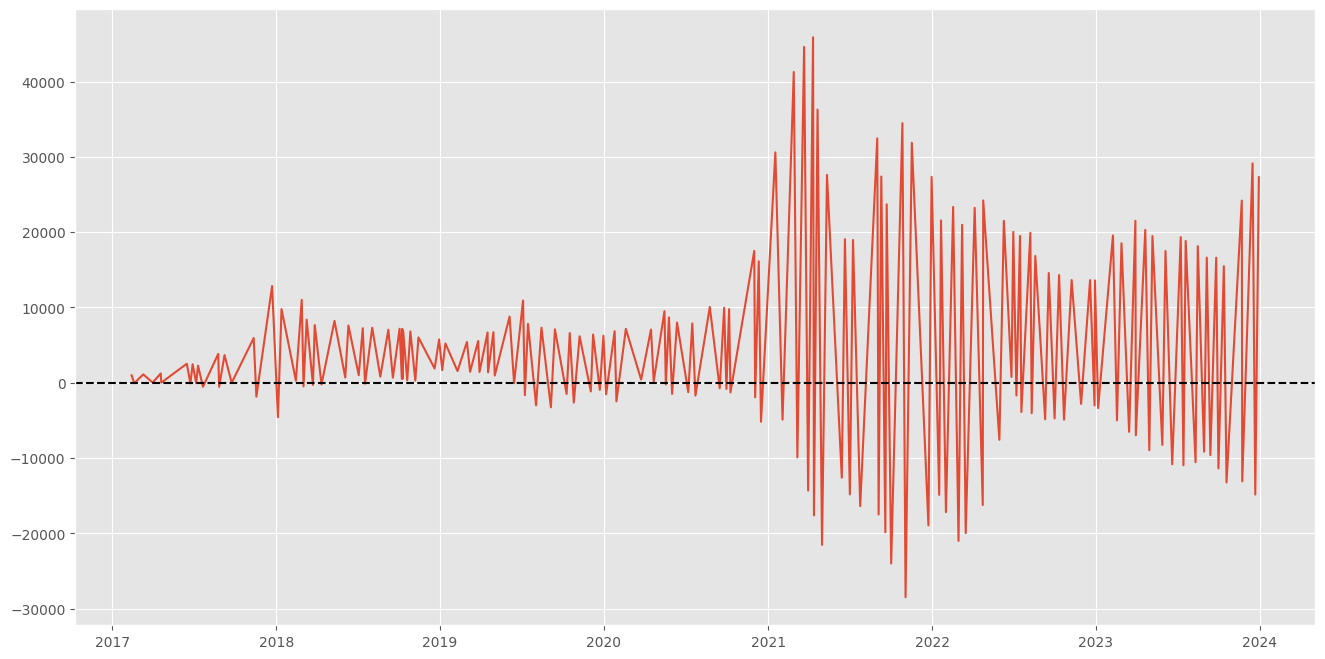

In [62]:
plt.figure(figsize=(16,8))
plt.plot(obj[0], np.cumprod(1+ obj[1]))
plt.axhline(y=0, color='black', linestyle='--')